### CNN on CIFAR10



    1.Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
    2.You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy.
    3.You cannot use Dense Layers (also called fully connected layers), or DropOut.
    4.You MUST use Image Augmentation Techniques.
    5.You cannot use an already trained model as a beginning points, you have to initilize as your own
    6.You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
    7.You cannot use test images for training the model.
    8.You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
    9.You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
    10.You cannot have more than 1 Million parameters in total
    11.You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc.
    12.You can use any optimization algorithm you need.
    13.You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch.



In [133]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [142]:
# Hyperparameters
batch_size = 32
num_classes = 10
epochs = 100
l = 6
num_filter = 35
compression = 1

In [143]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [144]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10)

In [145]:
#dense block
def denseblock(input, num_filter = 12):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

#transition block
def transition(input, num_filter = 12):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    conv = layers.Conv2D(num_classes, (1,1), use_bias=False ,padding='same')(AvgPooling)
    maxpooling = layers.GlobalMaxPooling2D()(conv)
    output = layers.Activation('softmax')(maxpooling)
    return output

In [146]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter)
First_Transition = transition(First_Block, num_filter)

Second_Block = denseblock(First_Transition, num_filter)
Second_Transition = transition(Second_Block, num_filter)

Third_Block = denseblock(Second_Transition, num_filter)
Third_Transition = transition(Third_Block, num_filter)

Last_Block = denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

In [147]:
#https://keras.io/api/preprocessing/image/#imagedatagenerator-class
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.1,
    shear_range=0.2,
)

In [148]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_597 (Conv2D)             (None, 32, 32, 35)   945         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_584 (BatchN (None, 32, 32, 35)   140         conv2d_597[0][0]                 
__________________________________________________________________________________________________
activation_585 (Activation)     (None, 32, 32, 35)   0           batch_normalization_584[0][0]    
____________________________________________________________________________________________

In [149]:
# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


In [150]:
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(x_train, y_train,
                                   batch_size=batch_size),
                                   epochs=epochs,
                                   validation_data=(x_val, y_val),
                                   workers=4)

Epoch 1/100
1407/1407 [==============================] - 44s 31ms/step - loss: 1.5598 - accuracy: 0.4303 - val_loss: 1.2470 - val_accuracy: 0.5570
Epoch 2/100
1407/1407 [==============================] - 43s 31ms/step - loss: 1.1240 - accuracy: 0.6007 - val_loss: 1.4426 - val_accuracy: 0.5568
Epoch 3/100
1407/1407 [==============================] - 43s 31ms/step - loss: 0.9169 - accuracy: 0.6790 - val_loss: 1.0549 - val_accuracy: 0.6628
Epoch 4/100
1407/1407 [==============================] - 43s 31ms/step - loss: 0.7968 - accuracy: 0.7218 - val_loss: 0.8773 - val_accuracy: 0.7060
Epoch 5/100
1407/1407 [==============================] - 43s 31ms/step - loss: 0.7101 - accuracy: 0.7527 - val_loss: 0.8849 - val_accuracy: 0.7084
Epoch 6/100
1407/1407 [==============================] - 44s 31ms/step - loss: 0.6529 - accuracy: 0.7734 - val_loss: 0.7550 - val_accuracy: 0.7516
Epoch 7/100
1407/1407 [==============================] - 43s 31ms/step - loss: 0.6022 - accuracy: 0.7912 - val_loss: 0

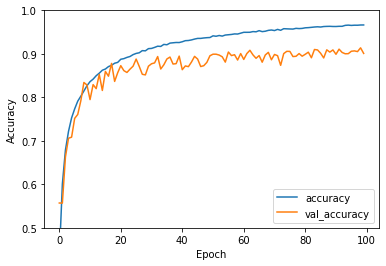

In [151]:
import matplotlib.pyplot as plt

#val accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [152]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 - 3s - loss: 0.3668 - accuracy: 0.9043
Test loss: 0.366832971572876
Test accuracy: 0.9042999744415283


In [153]:
# Save the trained weights in to .h5 format
model.save_weights("DenseNet_CIFAR10.h5")
print("Saved model to disk")

Saved model to disk


## Conclusion 
1. Test accuracy is 90.42 and Train accuracy is 96.64 so there is a bit of overfitting.
2. We have used the same architecture for DenseNet.
3. Used Image Augmentation techniques like zoom level, shear range, rotation range, etc.